In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import re
import networkx as nx
from networkx.algorithms import bipartite

In [2]:
# import custom networkx modifications & scraping functions
import networkx_util 

Using the same data that I scraped from Facebook and used for Project 1, I created a bipartite network by converting the `Study` attribute of the `friend` node into a separate `school` node. For the purposes of this project, I removed all other attributes. 

All of the scraping code and some modifications to the networkx functions to allow saving are included in the `networkx_util` library I imported above. 

Below, I'm simply testing to that the `networkx_util` functions are working correctly, and I was able to plot the network graph of just the `friend` nodes. 

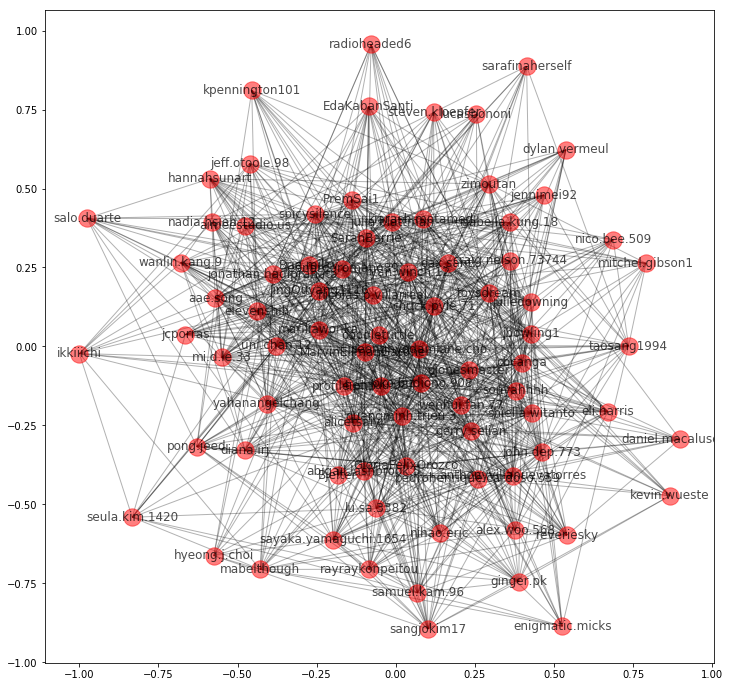

In [4]:
g3 = networkx_util.read_pajek_('/Users/bhao1/Desktop/facebook_network.net')

plt.figure(3,figsize=(12,12)) 
networkx_util.show_network(g3)
plt.show()

The code below is where I'm converting the `Study` attribute into the `school` node. At the time of scraping, the data comes in a variety of forms, e.g. `Studied at Academy of Art University from 2014 to 2018 Past: San Francisco State University and Albany High School` with some variation, so I used regex to parse out just the schools and standardize them. 

In [10]:
# parse g3 graph Study attribute for schools attended
schools_list = []
friends_list = []
# for some reason these friends cause the graph to be ambiguous/disconnected
excl_list = ['mi.d.le.33', 'MarvinEllmanGardner', 'sarafinaherself', 'steven.kloepfer', 'juliedowning', 'jeff.otoole.98', 'daniel.macaluso.50']
for friend in list(g3.nodes):
    if friend not in excl_list:
        try:
            if g3.node[friend]['Study'] not in schools_list:
                schools_list.append(g3.node[friend]['Study'])
                friends_list.append(friend)
        except:
            pass

schools_list_clean = []
for study in schools_list:
    # most recent school
    study = re.sub(r"Jan |Feb |Mar |Apr |May |Jun |Jul |Aug |Sep |Oct |Nov |Dec ", "", study)
    if len(re.findall("(Past:|Class of|\d{4} to)", study)) == 0:
        school = re.findall(" at (.*)", study)
        schools_list_clean.append(school[0])
    else:
        school = re.findall(" at (.*)\s(Past:|Class of|\d{4} to)", study)
        schools_list_clean.append(school[0][0])
    # previously attended schools
    if len(re.findall(" Past: (.*)", study)) > 0:
        study_and = re.findall(" Past: (.*)", study)
        if len(re.findall("(.*) and (.*)", study_and[0])) > 0:
            schools_list_clean.append(re.findall("(.*) and (.*)", study_and[0])[0][0])
            schools_list_clean.append(re.findall("(.*) and (.*)", study_and[0])[0][1])
        else:
            schools_list_clean.append(study_and[0])
schools_list_clean = list(set(schools_list_clean))

With a clean list of friends and schools, I created a new bipartite graph in the code below. For some reason, Networkx was a bit picky about some of the friends I included and would not recognize the graph as bipartite if I included them (which is why they've been excluded in the step above). 

In [ ]:
# create graph and add nodes to graph
g_bipart = nx.Graph()
g_bipart.add_nodes_from(friends_list, bipartite=0)
g_bipart.add_nodes_from(schools_list_clean, bipartite=1)

# add edges to graph
edge_list = []
for school in schools_list_clean:
    for friend in friends_list:
        try:
            if school in g3.node[friend]['Study']:
                # print(tuple((school, friend)))
                edge_list.append(tuple((school, friend)))
        except:
            pass
g_bipart.add_edges_from(edge_list)

# group nodes
# nx.is_connected(g_bipart)  # check if network is connected 
bottom_nodes, top_nodes = bipartite.sets(g_bipart)

With the bipartite graph created, I was then able to do some analyses on the network. The first thing I looked at was a visualization of the network with the `friend` and `school` nodes styled differently. The visualization probably looks different than most network graphs with a clear center and distinct rings around it. This is actually not surprising given how I assembled the data. I started with a student from the Academy of Art University (the center blue `school` node) and applying the snowball technique added friends and friends-of-friends (the red `friend` nodes surrounding the center node). While most of these friends attended the same Academy of Art University, they attended a very different set of schools prior to the Academy of Art (the blue `school` nodes surrounding the red ring). 

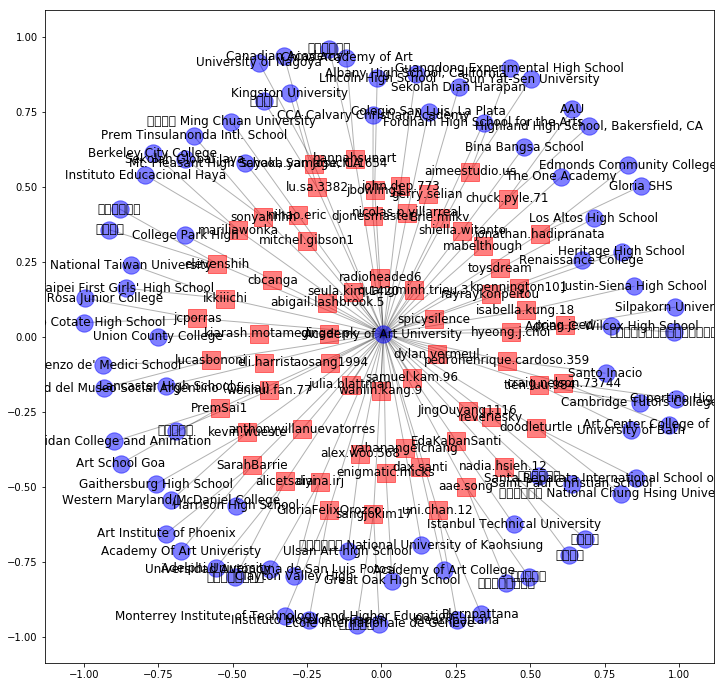

In [11]:
plt.figure(3,figsize=(12,12)) 
pos=nx.spring_layout(g_bipart)
nx.draw_networkx_edges(g_bipart, pos, alpha=0.3)
nx.draw_networkx_nodes(g_bipart, pos, node_shape='s', nodelist=bottom_nodes, node_color='r', alpha=0.5)
nx.draw_networkx_nodes(g_bipart, pos, node_shape='o', nodelist=top_nodes, node_color='b', alpha=0.5)
nx.draw_networkx_labels(g_bipart, pos)
plt.show()

Although the central node and the surrounding friends formation may not be surprising, it is interesting that the outer ring of blue nodes contains so many different schools. If compared to a state school, like San Francisco State University, we will likely find that students at the Academy of Art University attended a much more diverse set of schools prior to the Academy. 

Because of this, we can infer that the Academy of Art University attracts students from all over the world (at least relative to many state schools which tend to attract many more local students). Without looking at the data, it is tough to say precisely, but we can also likely infer that the students at the Academy are much more loosely connected to each other than students at a state school, where students likely all come from the same or similar communities. 